In [5]:
import pandas as pd

df = pd.read_csv("loan_data.csv")   # change filename to your CSV
print("shape:", df.shape)
print(df.columns.tolist())
print(df.head())
print("\nUnique values in Loan_Status (target):", df['Loan_Status'].unique())


shape: (614, 13)
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4           

In [6]:
print(df.info())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education  

In [8]:
import pandas as pd
import numpy as np

# 1) Drop Loan_ID (not useful)
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])

# 2) Fill missing values:
#   - categorical → mode, numeric → median
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])   # ✅ no inplace
    else:
        df[col] = df[col].fillna(df[col].median())    # ✅ no inplace

# 3) Map target to binary (1 = approved, 0 = not)
target = 'Loan_Status'   # change if your file uses different name
if df[target].dtype == object:
    unique = list(df[target].unique())
    print("Target unique values:", unique)
    if 'Y' in unique or 'N' in unique:
        df[target] = df[target].map({'Y':1,'N':0})
    elif 'Approved' in unique or 'Rejected' in unique:
        df[target] = df[target].map({'Approved':1, 'Rejected':0})
    else:
        try:
            df[target] = df[target].astype(int)
        except:
            raise ValueError("Please check the target column values and map them to 0/1 manually.")
else:
    df[target] = df[target].astype(int)

# 4) One-hot encode categorical variables
X = df.drop(columns=[target])
y = df[target]

X = pd.get_dummies(X, drop_first=True)

print("X shape after encoding:", X.shape)
print("Class distribution:\n", y.value_counts())


X shape after encoding: (614, 14)
Class distribution:
 Loan_Status
1    422
0    192
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


(491, 14) (123, 14)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# scale features for LR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# train
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# predict & evaluate
y_pred_lr = lr.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))


Accuracy: 0.8617886178861789

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



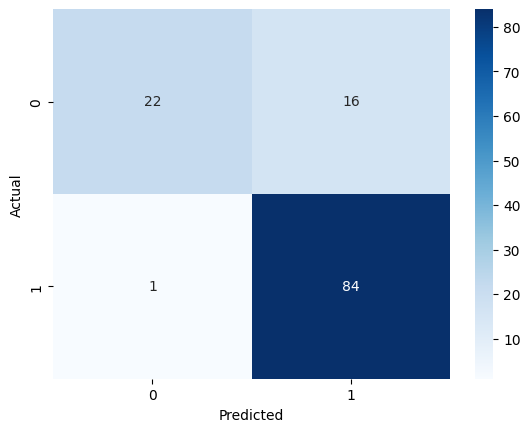

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print("After SMOTE class counts:", pd.Series(y_res).value_counts())


After SMOTE class counts: Loan_Status
1    337
0    337
Name: count, dtype: int64


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Logistic on resampled
lr2 = LogisticRegression(max_iter=1000, random_state=42)
lr2.fit(X_res, y_res)
y_pred_lr2 = lr2.predict(X_test_scaled)

# RandomForest on resampled (no scaling required, but we trained on scaled features so use X_res)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test_scaled)

from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

print_metrics("Logistic (after SMOTE)", y_test, y_pred_lr2)
print_metrics("RandomForest (after SMOTE)", y_test, y_pred_rf)


--- Logistic (after SMOTE) ---
Accuracy: 0.8130081300813008
Precision: 0.8604651162790697
Recall: 0.8705882352941177
F1-score: 0.8654970760233918
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        38
           1       0.86      0.87      0.87        85

    accuracy                           0.81       123
   macro avg       0.78      0.78      0.78       123
weighted avg       0.81      0.81      0.81       123

--- RandomForest (after SMOTE) ---
Accuracy: 0.8292682926829268
Precision: 0.8636363636363636
Recall: 0.8941176470588236
F1-score: 0.8786127167630058
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        38
           1       0.86      0.89      0.88        85

    accuracy                           0.83       123
   macro avg       0.80      0.79      0.80       123
weighted avg       0.83      0.83      0.83       123



In [14]:
results = []
for name, pred in [("LR baseline", y_pred_lr), ("LR + SMOTE", y_pred_lr2), ("RF + SMOTE", y_pred_rf)]:
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "f1": f1_score(y_test, pred)
    })
pd.DataFrame(results).set_index("model")


,accuracy,precision,recall,f1
model,,,,
LR baseline,0.861789,0.840000,0.988235,0.908108
LR + SMOTE,0.813008,0.860465,0.870588,0.865497
RF + SMOTE,0.829268,0.863636,0.894118,0.878613


In [15]:
import joblib
best_model = rf   # choose whichever performed best
joblib.dump(best_model, 'best_loan_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Saved model and scaler.")


Saved model and scaler.
